# Problem Statement

Build an optimal model that can help us identify bot traffic coming  from search engines (NHT-search), other bot traffic (NHT-other) and human traffic (HT).

# Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [2]:
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# For processing and maths
import numpy as np
import pandas as pd
import re
import requests
import pickle

In [4]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 2)-Loading datasets 

In [5]:
df_bol =pd.read_csv('clickdata.csv')
df_bol.shape

(59782, 8)

In [6]:
df_bol.columns

Index(['epoch_ms', 'session_id', 'country_by_ip_address',
       'region_by_ip_address', 'url_without_parameters',
       'referrer_without_parameters', 'visitor_recognition_type',
       'ua_agent_class'],
      dtype='object')

In [7]:
df_bol.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,NaN,ANONYMOUS,Robot
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,NaN,ANONYMOUS,Robot
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,NaN,ANONYMOUS,Robot
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,NaN,ANONYMOUS,Robot Mobile


In [8]:
df_bol.tail()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
59777,1520287193332,6a98ec825aa0ccdc2aefb0d02f291cde,NL,NH,https://www.bol.com/nl/p/gladskin-rosacea-gel-...,NaN,RECOGNIZED,Browser
59778,1520287193930,70664825c07eeb2af81c77e7ef6f7493,US,CA,https://www.bol.com/nl/p/homedecoration-toront...,NaN,ANONYMOUS,Robot
59779,1520287196302,99935d53a2f5d6e95adaecba3ec288e6,US,CA,https://www.bol.com/nl/l/witte-nike-sportshirt...,NaN,ANONYMOUS,Robot
59780,1520287197700,0bff91927029f6402eff065680b0d8d8,US,CA,https://www.bol.com/nl/l/gadgetbay-randapparat...,NaN,ANONYMOUS,Robot
59781,1520287199048,01201ebb918c64ea4dabdabdfbcbd1b0,NL,NaN,https://www.bol.com/nl/p/hp-z3700-draadloze-mu...,NaN,ANONYMOUS,Browser


# 3)-Data Exploring

### 3.1)- Checking data-type

In [9]:
# Checking all variables with their data-type
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(df_bol)
table_dtype

,Data Type
epoch_ms,int64
session_id,object
country_by_ip_address,object
region_by_ip_address,object
url_without_parameters,object
referrer_without_parameters,object
visitor_recognition_type,object
ua_agent_class,object


### 3.2)- Checking missing values

In [10]:
def summary_missing(dataset):
    n_miss = dataset.isnull().sum()
    n_obs = dataset.shape[0]
    n_miss_per = n_miss/n_obs*100
    n_miss_tbl = pd.concat([n_miss, n_miss_per], axis = 1).sort_values(1, ascending = False).round(1)
    n_miss_tbl = n_miss_tbl[n_miss_tbl[1] != 0]
    print('No. of fields: ', dataset.shape[0])
    print('No. of missing fields: ', n_miss_tbl.shape[0])
    n_miss_tbl = n_miss_tbl.rename(columns = {0:'No. of mising Value', 1:'%age of missing Value'})
    return n_miss_tbl

In [11]:
summary_missing(df_bol)

No. of fields:  59782
No. of missing fields:  3


,No. of mising Value,%age of missing Value
referrer_without_parameters,44778,74.9
region_by_ip_address,9896,16.6
country_by_ip_address,248,0.4


In [12]:
# checking each feature one by one starting with "referrer_without_parameters"

#df_bol['referrer_without_parameters'].value_counts(dropna=False)

In [13]:
df_bol['country_by_ip_address'].value_counts(dropna=False)

NL     25673
US     22780
BE      7409
GB      1185
DE       616
FR       348
NaN      248
CN       236
UA       192
RU       105
ES        90
IE        89
PL        81
JP        80
IT        74
CA        65
PT        62
CH        42
NZ        35
GR        30
QA        29
SE        26
BR        23
BD        21
TR        16
ID        16
AU        15
IR        14
HU        14
AT        13
       ...  
CZ         8
TH         8
DK         7
BG         7
SR         6
PK         5
MK         5
MD         4
VN         4
LV         4
GH         4
AL         3
LT         3
ZA         3
KR         3
AM         2
MA         2
SO         2
PY         2
AR         1
SK         1
DO         1
LU         1
MX         1
IL         1
MC         1
KG         1
BO         1
CW         1
MN         1
Name: country_by_ip_address, Length: 66, dtype: int64

In [14]:
df_bol['region_by_ip_address'].value_counts(dropna=False)

CA     20662
NaN     9896
NH      4320
ZH      4160
VAN     2239
NB      2112
GE      1950
UT      1586
VOV     1333
OV      1055
VWV      821
ENG      736
VLI      730
LI       707
BRU      699
OK       682
GR       571
FL       533
VBR      528
FR       480
DR       436
ZE       356
BJ       234
NY       229
VA       203
WA       137
BOL      122
30       104
NJ        90
11        74
       ...  
26         1
GC         1
29         1
31         1
WKO        1
VD         1
AM         1
CE         1
KP         1
15         1
TA         1
VGG        1
KHE        1
BEN        1
41         1
WLX        1
ENF        1
UP         1
86         1
CMX        1
531        1
LT         1
61         1
06         1
KEN        1
IRK        1
BL         1
TO         1
202        1
ME         1
Name: region_by_ip_address, Length: 229, dtype: int64

We could either remove these missing values or we might fill them with an "entity". If it were numerical data then I would add 0. As it is categorical data , we might add"various" or as training model suggests , we may also add ''. I will use same code as given

In [15]:
df_bol.replace(np.nan, '', regex=True, inplace=True)
df_bol.replace('Unknown', '', regex=True, inplace=True)

In [16]:
summary_missing(df_bol)

No. of fields:  59782
No. of missing fields:  0


,No. of mising Value,%age of missing Value


Seems fine now

### 3.3)-checking duplicate values

In [17]:
print(df_bol.duplicated().sum())

0


### 3.4)-Sorting

In [18]:
df_bol.sort_values(by='visitor_recognition_type', ascending=False).head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
34496,1520280202558,da3b7564f35e8f28451ae65a9a9b66d1,NL,,https://www.bol.com/nl/b/ajax/index.html,https://www.bol.com/nl/b/baby-kinderkleding-jo...,RECOGNIZED,Browser
27702,1520281427095,b394bfb124a91cd9ebbedd4f14d5e4b0,BE,VAN,https://www.bol.com/nl/p/swampworld-dionaea-mu...,https://www.bol.com/nl/s/tuin/zoekresultaten/N...,RECOGNIZED,Browser
27721,1520281441407,e3d49b10074a12986d8868dd85835fb6,BE,,https://www.bol.com/nl/p/sistema-bake-it-versh...,https://www.bol.com/nl/s/algemeen/zoekresultat...,RECOGNIZED,Browser
12747,1520283062812,03988ce8b205597d44bc571d8a04162a,NL,GE,https://www.bol.com/nl/s/ajax/index.html,https://www.bol.com/nl/s/algemeen/zoekresultat...,RECOGNIZED,Browser
27716,1520281439193,01302b8ffd4ccc060e926d01171651c7,NL,,https://www.bol.com/nl/p/wereldbol-met-verlich...,,RECOGNIZED,Browser


In [19]:
df_bol.sort_values(by=['ua_agent_class', 'visitor_recognition_type'], ascending=[True, False]).head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
9,1520280013619,d3828e7e2638881c9b0f3bed0221f815,NL,ZH,https://www.bol.com/nl/t/elektronica/audio-hif...,,RECOGNIZED,Browser
19,1520280023995,6c3d7350dee7687fe8a550951ae2ad4a,NL,ZH,https://www.bol.com/nl/checkout/login.html,,RECOGNIZED,Browser
26,1520280033070,160fdd31c0a5ecfb6e27d0c9e99eceaa,NL,UT,https://www.bol.com/nl/p/ducksday-zomer-poncho...,https://www.bol.com/nl/s/algemeen/zoekresultat...,RECOGNIZED,Browser
37,1520280038110,13f24291bd85342a43c4afbdad7c6e9c,NL,GR,https://www.bol.com/nl/ra/boeken/gratis-verzen...,,RECOGNIZED,Browser
39,1520280039188,8e2499565ca2b5a8a1ece6080e09af5d,NL,NB,https://www.bol.com/nl/c/ajax/index.html,,RECOGNIZED,Browser


### groupby

In [20]:
df_bol.groupby(['ua_agent_class']).count()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type
ua_agent_class,,,,,,,
Browser,35509,35509,35509,35509,35509,35509,35509
Browser Webview,1800,1800,1800,1800,1800,1800,1800
Cloud Application,2,2,2,2,2,2,2
Hacker,1177,1177,1177,1177,1177,1177,1177
Mobile App,9,9,9,9,9,9,9
Robot,16026,16026,16026,16026,16026,16026,16026
Robot Mobile,5115,5115,5115,5115,5115,5115,5115
Special,144,144,144,144,144,144,144


In [21]:
df_bol.groupby(['ua_agent_class', 'visitor_recognition_type']).count()

epoch_ms  session_id  \
ua_agent_class    visitor_recognition_type                         
Browser           ANONYMOUS                    20390       20390   
                  LOGGEDIN                      3076        3076   
                  RECOGNIZED                   12043       12043   
Browser Webview   ANONYMOUS                      849         849   
                  LOGGEDIN                       406         406   
                  RECOGNIZED                     545         545   
Cloud Application ANONYMOUS                        2           2   
Hacker            ANONYMOUS                     1176        1176   
                  RECOGNIZED                       1           1   
Mobile App        ANONYMOUS                        9           9   
Robot             ANONYMOUS                    16026       16026   
Robot Mobile      ANONYMOUS                     5115        5115   
Special           ANONYMOUS                      144         144   

                                            country_by_ip_address  \
ua_agent_class    visitor_recognition_type                          
Browser           ANONYMOUS                                 20390   
                  LOGGEDIN                                   3076   
                  RECOGNIZED                                12043   
Browser Webview   ANONYMOUS                                   849   
                  LOGGEDIN                                    406   
                  RECOGNIZED                                  545   
Cloud Application ANONYMOUS                                     2   
Hacker            ANONYMOUS                                  1176   
                  RECOGNIZED                                    1   
Mobile App        ANONYMOUS                                     9   
Robot             ANONYMOUS                                 16026   
Robot Mobile      ANONYMOUS                                  5115   
Special           ANONYMOUS                                   144   

                                            region_by_ip_address  \
ua_agent_class    visitor_recognition_type                         
Browser           ANONYMOUS                                20390   
                  LOGGEDIN                                  3076   
                  RECOGNIZED                               12043   
Browser Webview   ANONYMOUS                                  849   
                  LOGGEDIN                                   406   
                  RECOGNIZED                                 545   
Cloud Application ANONYMOUS                                    2   
Hacker            ANONYMOUS                                 1176   
                  RECOGNIZED                                   1   
Mobile App        ANONYMOUS                                    9   
Robot             ANONYMOUS                                16026   
Robot Mobile      ANONYMOUS                                 5115   
Special           ANONYMOUS                                  144   

                                            url_without_parameters  \
ua_agent_class    visitor_recognition_type                           
Browser           ANONYMOUS                                  20390   
                  LOGGEDIN                                    3076   
                  RECOGNIZED                                 12043   
Browser Webview   ANONYMOUS                                    849   
                  LOGGEDIN                                     406   
                  RECOGNIZED                                   545   
Cloud Application ANONYMOUS                                      2   
Hacker            ANONYMOUS                                   1176   
                  RECOGNIZED                                     1   
Mobile App        ANONYMOUS                                      9   
Robot             ANONYMOUS                                  16026   
Robot Mobile      ANONYMOUS                             

### 3.4)- Checking categorical features

In [22]:
# Checking unique categorical variables
df_bol.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

session_id                     30816
country_by_ip_address             66
region_by_ip_address             229
url_without_parameters         40696
referrer_without_parameters     6203
visitor_recognition_type           3
ua_agent_class                     8
dtype: int64

Our feature of interests are "ua_agent" being our independant feature, country_by_ip_address, region_by_ip_address and visitor_recognition_type.

In [23]:
# checking how many unique labels are in each feature
df_bol['visitor_recognition_type'].unique()

array(['ANONYMOUS', 'LOGGEDIN', 'RECOGNIZED'], dtype=object)

In [24]:
# how many times those labels classes occur
df_bol['visitor_recognition_type'].value_counts()

ANONYMOUS     43711
RECOGNIZED    12589
LOGGEDIN       3482
Name: visitor_recognition_type, dtype: int64

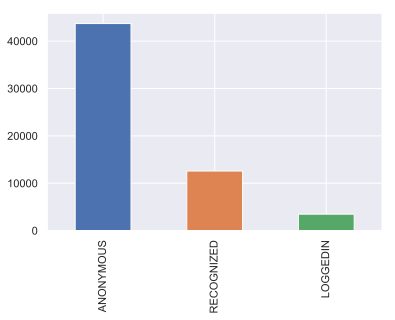

In [25]:
df_bol['visitor_recognition_type'].value_counts().plot.bar()

In [26]:
# Let's check other categorical variables such as country_by_ip_address

df_bol['country_by_ip_address'].unique()

array(['US', 'IT', 'NL', 'BE', '', 'UA', 'FR', 'DE', 'PL', 'CN', 'IE',
       'RU', 'GB', 'AT', 'HU', 'JP', 'CA', 'PT', 'ES', 'CH', 'LT', 'ID',
       'IN', 'TR', 'IR', 'MY', 'NZ', 'AU', 'TH', 'BD', 'QA', 'CZ', 'VN',
       'MN', 'IL', 'FI', 'AM', 'DK', 'SR', 'GR', 'SE', 'LV', 'PK', 'LU',
       'MA', 'MD', 'BG', 'BR', 'HR', 'AR', 'AL', 'MK', 'GH', 'PY', 'NO',
       'RO', 'BO', 'ZA', 'SO', 'MC', 'MX', 'KR', 'DO', 'CW', 'SK', 'KG'],
      dtype=object)

In [27]:
df_bol['country_by_ip_address'].value_counts()[:10]

NL    25673
US    22780
BE     7409
GB     1185
DE      616
FR      348
        248
CN      236
UA      192
RU      105
Name: country_by_ip_address, dtype: int64

In [28]:
df_bol['region_by_ip_address'].unique()

array(['CA', 'LI', 'NB', 'UT', 'ZH', '', 'GE', 'DR', 'GR', 'FL', 'BRU',
       'VAN', 'NH', 'OV', 'SO', 'VLI', 'FR', 'OK', '30', 'VWV', 'BW',
       'MZ', 'BJ', 'ZE', 'VOV', 'VBR', 'L', 'VLA', 'BOL', 'WA', '7', '5',
       'AZ', 'NY', 'PA', 'VA', 'BU', 'ENG', 'WHT', 'TN', '13', 'IL', 'NV',
       '69', 'WNA', 'AL', 'IN', 'ON', 'WLG', 'NJ', 'MN', '11', 'ND', 'AR',
       'DA', 'RM', 'QC', 'SD', 'TOM', 'ZG', '05', 'JI', 'HE', 'AP', '59',
       'CO', '08', '67', '03', '35', 'WBR', '14', 'AUK', 'NSW', '64',
       'MOS', '23', 'MD', 'ZP', '10', 'IA', 'LU', 'LA', '29', 'KP', 'HN',
       '1', 'NYK', 'TA', '18', 'BA', 'ER', '27', '07', '81', 'TX', 'NW',
       'IRK', 'CM', 'MI', '40', 'I', 'JK', 'SI', 'GA', '26', 'OR', 'MS',
       '24', '71', 'WKO', '9', 'NC', 'VGG', 'AB', 'LK', 'MOW', 'RIX',
       'PB', 'M', 'ME', 'SL', 'KHE', 'OH', 'ID', 'CT', 'MO', 'MA', '6',
       'NI', '12', 'GRE', 'BY', '92', 'CU', 'CAS', '20', 'A', 'GI', 'SH',
       'FI', 'SRY', 'BE', 'WI', 'NFK', 'ULY', '51', '2

In [29]:
df_bol['region_by_ip_address'].value_counts()[:10]

CA     20662
        9896
NH      4320
ZH      4160
VAN     2239
NB      2112
GE      1950
UT      1586
VOV     1333
OV      1055
Name: region_by_ip_address, dtype: int64

### 3.5)- Dependant Feature

In [30]:
df_bol['ua_agent_class'].unique()

array(['Robot', 'Browser', 'Robot Mobile', 'Browser Webview', 'Hacker',
       'Special', 'Mobile App', 'Cloud Application'], dtype=object)

In [31]:
df_bol.shape

(59782, 8)

I will choose to divide into only two categories according to our problem statement.Our categories are bot traffic coming  from search engines (NHT-search), other bot traffic (NHT-other) and human traffic (HT). 

- I will choose first a binary problem where we have only Non-human traffice and Human traffice.

- Second case will be for three classes where traffic coming  from search engines (NHT-search), other bot traffic (NHT-other) and human traffic (HT) will be considered

**I am not sure about what special is. So, I ll remove it from our category**

In [32]:
df_bol = df_bol[~df_bol['ua_agent_class'].isin(['Special'])]
df_bol.shape

(59638, 8)

In [33]:
df_bol.ua_agent_class.value_counts()

Browser              35509
Robot                16026
Robot Mobile          5115
Browser Webview       1800
Hacker                1177
Mobile App               9
Cloud Application        2
Name: ua_agent_class, dtype: int64

In [34]:
df_bol['labels'] = df_bol.ua_agent_class.map({'Robot':'NHT', 'Robot Mobile':'NHT','Browser':'HT', 'Browser Webview':'HT','Hacker':'HT','Mobile App':'HT','Cloud Application':'HT'})

In [35]:
df_bol.labels.value_counts()

HT     38497
NHT    21141
Name: labels, dtype: int64

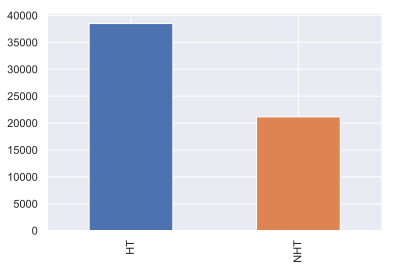

In [36]:
df_bol.labels.value_counts().plot(kind='bar')

In [37]:
# create dataframe for feature of interest
df_foi=df_bol[['labels','visitor_recognition_type','country_by_ip_address','region_by_ip_address']]

In [38]:
df_foi.head()

,labels,visitor_recognition_type,country_by_ip_address,region_by_ip_address
0,NHT,ANONYMOUS,US,CA
1,NHT,ANONYMOUS,US,CA
2,HT,ANONYMOUS,IT,LI
3,NHT,ANONYMOUS,US,CA
4,NHT,ANONYMOUS,US,CA


### Checking ANONYMOUS traffice role in data
As we have now more concise data classification so, we might want to check again 

**This "ANONYMOUS" class in visitor_recognition_type feature is interesting. It could be that bot searches are mostly ANONYMOUS. It is only an assumption. Let's see if data supports it**

In [39]:
c=df_foi

In [40]:
c=c[(c.visitor_recognition_type == 'ANONYMOUS')]
c=c.groupby(['labels','visitor_recognition_type']).size()

In [41]:
c

labels  visitor_recognition_type
HT      ANONYMOUS                   22426
NHT     ANONYMOUS                   21141
dtype: int64

**There is not much difference. So, my assumption that "ANONYMOUS" is related to Non-human traffic does not hold ground.**


In [42]:
df_foi.groupby(['labels', 'visitor_recognition_type']).count()

country_by_ip_address  region_by_ip_address
labels visitor_recognition_type                                             
HT     ANONYMOUS                                 22426                 22426
       LOGGEDIN                                   3482                  3482
       RECOGNIZED                                12589                 12589
NHT    ANONYMOUS                                 21141                 21141


one thing is for sure that all NHT is in ANONYMOUS category as seen above.

In [43]:
#df_foi.groupby(['labels', 'country_by_ip_address']).count()

# 4)- Saving file for future use

- Create binary classification
- Create multi-classification

**Save file as pickle for binary classification**

In [44]:
df_foi.to_pickle('clickdata.pkl')

### for multi-classification